# TOPIC EXTRACTION

## Topic Assignment Consistency

In [13]:
from gensim import corpora, models
import gensim

In [8]:
import numpy as np
import random
import pickle

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Train LDA models with different number of topics

In [ ]:
texts = pickle.load(open('pub_articles_cleaned_super.pkl','rb'))

random.seed(42)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]

pickle.dump([train_set,test_set,train_texts,test_texts],open('pub_articles_train_test_sets.pkl','wb'))

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

dictionary = corpora.Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_bow[i] = models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
    ldamodels_bow[i].save('ldamodels_bow_'+str(i)+'.lda')

Evaluate on 1,000 documents **not** used in LDA training

In [ ]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
def intra_inter(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[dictionary.doc2bow(tokens[:int(len(tokens)/2)])] for tokens in test_docs]
    part2 = [lda_model[dictionary.doc2bow(tokens[int(len(tokens)/2):])] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [ ]:
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('pub_ldamodels_eval.pkl','wb'))

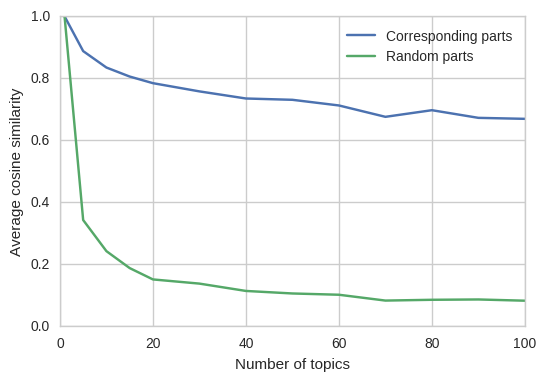

In [10]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

ldamodels_eval = pickle.load(open('pub_ldamodels_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]

with sns.axes_style("whitegrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.plot(x,y1,label='Corresponding parts')
    plt.plot(x,y2,label='Random parts')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity')    
    plt.legend()    
    plt.show()

## Topic Stability Analysis

Measure overlap between topic vectors from different numbers of topics

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('pub_lda_topics.pkl','wb'))

In [ ]:
# http://billchambers.me/tutorials/2014/12/21/tf-idf-explained-in-python.html
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [ ]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('pub_lda_stability.pkl','wb'))

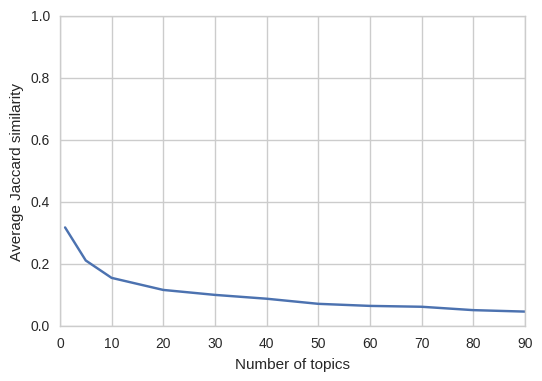

In [11]:
topicnums = [1,5,10,20,30,40,50,60,70,80,90,100]

lda_stability = pickle.load(open('pub_lda_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("whitegrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Mean overlap')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')    
    #plt.legend()    
    plt.show()

## Number of Topics = 20

In [ ]:
num_topics = 20
lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(num_topics)+'.lda')

In [14]:
lda_topics = lda_model.show_topics(num_topics)
lda_topics_words = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics]
lda_topics_disp = [("topic "+str(i)+": ")+" ".join(topic) for i,topic in enumerate(lda_topics_words)]
lda_topics_disp

['topic 0: trump say president russia state russian will intelligence official unite',
 'topic 1: woman say school march student right abortion people education life',
 'topic 2: will china world say now may country year make people',
 'topic 3: vote state say voter election republican romney trump campaign party',
 'topic 4: say police city officer report twitter department official shoot people',
 'topic 5: say year climate water land record scientist time change find',
 'topic 6: trump say president percent will trade business company government american',
 'topic 7: say year tell court time take gun case go old',
 'topic 8: say year people home state death snow kill storm family',
 'topic 9: say trump senate president nominee will hear committee secretary state',
 'topic 10: trump say news spicer press medium president time claim million',
 'topic 11: trump mexico border say wall will president mexican immigration trade',
 'topic 12: say year music song new will make time like firs

Get topic distributions / probabilities for each article

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [ ]:
with open ("bubble_popper_postgres.txt","r") as myfile:
    lines = [line.replace("\n","") for line in myfile.readlines()] 
db, us, pw = 'bubble_popper', lines[0], lines[1]                     
engine = create_engine('postgresql://%s:%s@localhost:5432/%s'%(us,pw,db))
connstr = "dbname='%s' user='%s' host='localhost' password='%s'"%(db,us,pw)
conn = None; conn = psycopg2.connect(connstr)

In [ ]:
articles = pickle.load(open('pub_articles_trimmed.pkl','rb')) # Article full content and other data
documents = pickle.load(open('pub_articles_cleaned_super.pkl','rb')) # Article preprocessed bag of words

doc_probs = []
for doc in documents:
    doc_dict = gensim.corpora.Dictionary([doc])
    doc_corp = doc_dict.doc2bow(doc)
    doc_probs.append(ldamodel[doc_corp])

articles = articles.drop(['content','title','url'],axis=1)
for i in range(0,num_topics):
    articles['topic'+str(i)] = 0.0
    
indices = articles.index.values.tolist()
for i, doc in list(zip(indices, doc_probs)):
    for probs in doc:
        articles.set_value(i,'topic'+str(probs[0]),probs[1])
        
pickle.dump(articles,open('pub_probabs_topic'+str(num_topics)+'.pkl','wb'))
articles.to_sql('article_data',engine,if_exists='replace')